# Apply time series modelling using SARIMA

This notebook try to analyze the time-series data using Auto-regressive integrated moving average (ARIMA)

In [106]:
# import necessary packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import sys
sys.path.append("../../PredictPIServer/ValePredictPI/")

from vale_connect import ValeConnect

In [107]:
# import PI Data on the same timeframe
# create connection
server_root = '142.40.33.208'
server_base = 'pti-pi'

conn = ValeConnect(server_root, server_base)

pi_tag = ['U-LGS1-UGB-X-PK-PK-70-AI','U-LGS1-UGB-Y-PK-PK-340-AI']
time_list = ['2023-10-11 16:07:48','2023-10-11 16:08:58']

for i in range(len(pi_tag)):
    x_tag_wid = conn.get_webid_point(pi_tag[i])

    # for limited data
    # value_resp = conn.get_stream_rec_valuetimestamp_pd(x_tag_wid, time_list)

    # for streaming data
    value_resp = conn.get_stream_rec_valuetime_pd(x_tag_wid)

    if i==0:
        data_pi = value_resp
    else:
        data_pi.insert(i+1, "Values " + str(i), value_resp['Values'])

data_pi

,Timestamps,Values,Values 1
0,2024-05-07T06:38:10.0151824Z,200.8,199.100000
1,2024-05-07T06:38:20.0077514Z,191.7,194.300000
2,2024-05-07T06:38:30.014328Z,186.0,198.700000
3,2024-05-07T06:38:40.0139007Z,190.2,210.000000
4,2024-05-07T06:38:50.0154876Z,193.6,188.700000
...,...,...,...
995,2024-05-07T09:27:00.029663Z,211.6,197.700000
996,2024-05-07T09:27:10.0232391Z,199.7,192.900009
997,2024-05-07T09:27:20.0268096Z,184.1,197.100000
998,2024-05-07T09:27:30.0173797Z,192.6,200.700000


In [98]:
# convert time series data 
for i in range(len(data_pi['Timestamps'])):
    date_str = data_pi['Timestamps'][i][11:19]
    #date_str = str(date_str)
         
    #date_format = '%H:%M:%S'
    #date_data = datetime.strptime(date_str, date_format)
    data_pi['Timestamps'][i] = date_str

/tmp/ipykernel_28156/2496222792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pi['Timestamps'][i] = date_str


In [108]:
data_pi.index[-1]

999

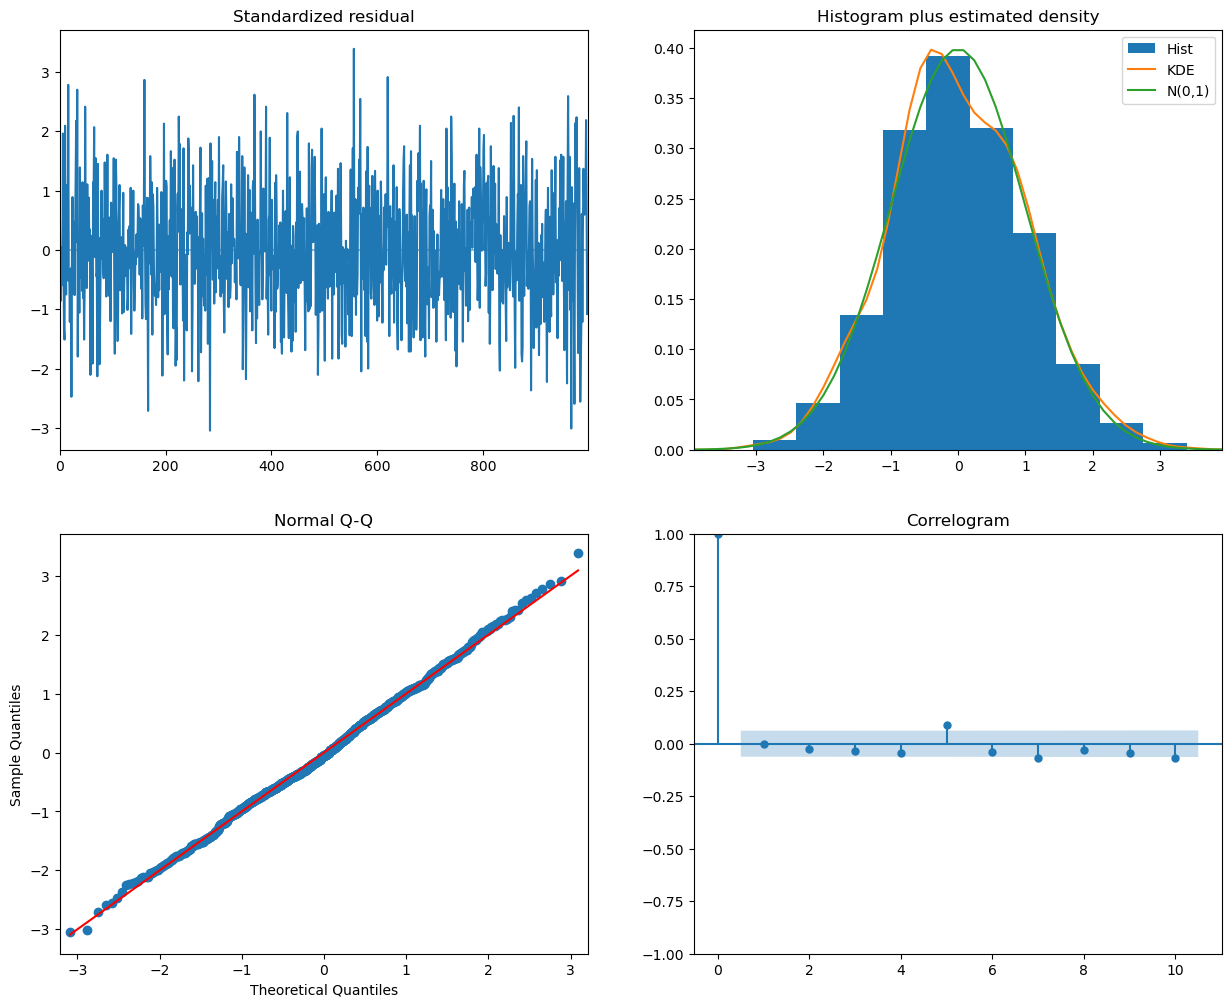

In [117]:
#Standard ARIMA Model
df = data_pi
SARIMA_model = pm.auto_arima(data_pi['Values'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      # max_p=3, max_q=3, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      D=1,
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='ignore', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

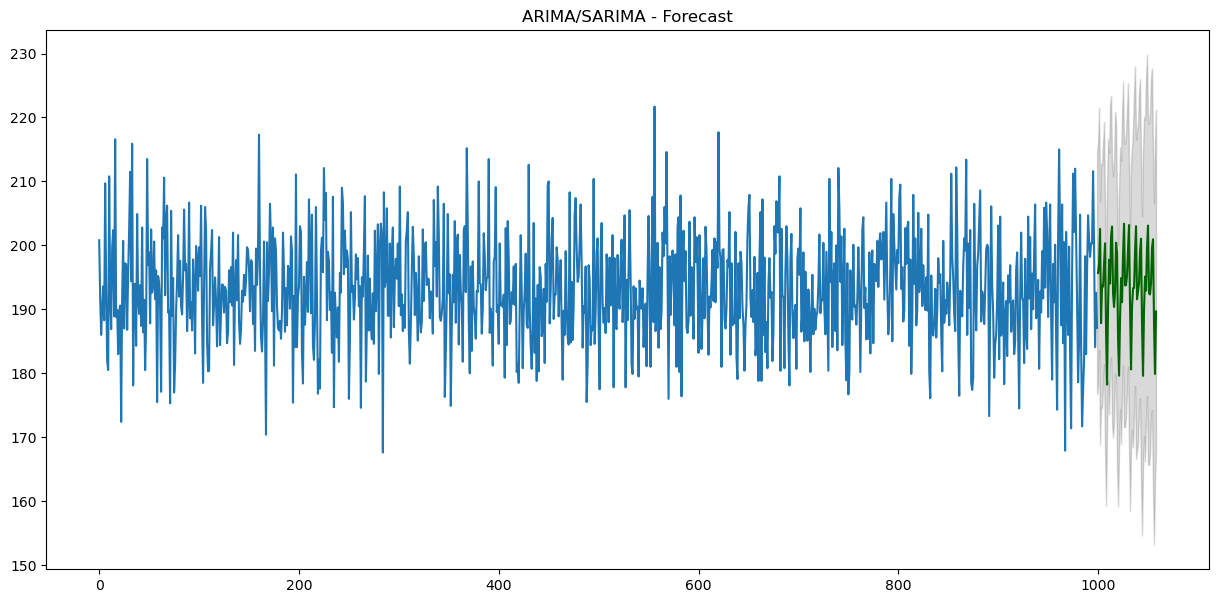

In [118]:
def forecast(ARIMA_model, periods=60):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = range(df.index[-1], df.index[-1] + n_periods, 1)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["Values"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast")
    plt.show()

forecast(SARIMA_model)